In [322]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import norm, skew

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_absolute_error

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor
import lightgbm as lgb 

from scipy.special import boxcox1p


import warnings
def ignore_warnings(*args, **kwargs):
    pass
warnings.warn = ignore_warnings

In [323]:
X_full = pd.read_csv("data/train.csv", index_col="Id")
X_test = pd.read_csv("data/test.csv", index_col="Id")

X=X_full.copy()

X.dropna(axis=0, subset=["SalePrice"], inplace=True)


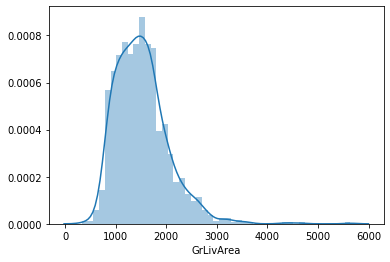

In [324]:
# remove outliers

sns.distplot(X.GrLivArea)

X = X[X.GrLivArea < 4500]

In [325]:
y = X.SalePrice
X.drop(["SalePrice"], axis=1, inplace=True)

In [326]:

test = pd.concat([X, X_test])

# Preprocessing

In [327]:
def preprocess(X):
    
    ########################################################################################
    #                                                                                      #
    #                                                                                      #
    #                                   NA Imputation                                      #
    #                                                                                      #
    #                                                                                      #
    ########################################################################################
    
    
    # Numeric

    X["LotFrontage"] = X.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.mode()[0]))

    X["MasVnrArea"] = X["MasVnrArea"].fillna(0)
    X["GarageYrBlt"] = X["GarageYrBlt"].fillna(0)
    
    # Categorical

    X["Electrical"] = X["Electrical"].fillna(X["Electrical"].mode()[0])

    unknown_cols = ['Alley','MasVnrType', 'FireplaceQu', 'GarageType',
                 'GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature']

    bsmnt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

    for col in unknown_cols:
        X[col] = X[col].fillna("Unknown")

    for col in bsmnt_cols:
        X[col] = X[col].fillna("None")
        
        
    ########################################################################################
    #                                                                                      #
    #                                                                                      #
    #                               Feature Engineering                                    #
    #                                                                                      #
    #                                                                                      #
    ########################################################################################
    
    
    # Convert some numeric features into cat
    X["MSSubClass"] = X["MSSubClass"].apply(str)
    X["YrSold"] = X["YrSold"].apply(str)
    X["MoSold"] = X["MoSold"].apply(str)

    # Creating some new features

    X["Surface"] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']

    X["SqFootage"] = X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['1stFlrSF'] + X['2ndFlrSF']

    X["Bathrooms"] = (X['FullBath'] + (0.5 * X['HalfBath']) +
                      X['BsmtFullBath'] + (0.5 * X['BsmtHalfBath']))

    X["Porches"]   = (X['OpenPorchSF'] + X['3SsnPorch'] +
                      X['EnclosedPorch'] + X['ScreenPorch'] +
                      X['WoodDeckSF'])

    # Simplifying

    X["HasPool"] = X["PoolArea"].apply(lambda x: 1 if x > 0 else 0)
    X["Has2ndFloor"] = X["2ndFlrSF"].apply(lambda x: 1 if x > 0 else 0)
    X["HasGarage"] = X["GarageArea"].apply(lambda x: 1 if x > 0 else 0)
    X["HasBasement"] = X["TotalBsmtSF"].apply(lambda x: 1 if x > 0 else 0)
    X["HasFireplace"] = X["Fireplaces"].apply(lambda x: 1 if x > 0 else 0)
    
    
    ########################################################################################
    #                                                                                      #
    #                                                                                      #
    #                                       Skewness                                       #
    #                                                                                      #
    #                                                                                      #
    ########################################################################################
    
    numeric_cols = [col for col in X.columns if X[col].dtype != "object"]
    skewness = X[numeric_cols].apply(lambda x: skew(x.dropna()))
    skewness = pd.DataFrame({'Skew': skewness})
    skewness = skewness[abs(skewness) > 0.5]
    
    lam = 0.15
    
    for col in skewness.index:
        X[col] = boxcox1p(X[col], lam)
        
        
    
    # Dummy Variables
        
    X = pd.get_dummies(X)
    
    return X

In [328]:
test_pr = preprocess(test)

X_pr = test_pr.loc[X.index,:]
X_test_pr = test_pr.loc[X_test.index,:]

In [329]:
#X_pr = preprocess(X)
#X_test_pr = preprocess(X_test)

X_train, X_valid, y_train, y_valid = train_test_split(X_pr, y, train_size=0.8, test_size=0.2)

In [268]:
cols = [col for col in X_pr.columns if col not in X_test_pr.columns]

cols

[]

In [246]:
#X_test_pr.drop(['MSSubClass_150'], axis=1, inplace=True)

In [330]:
model = XGBRegressor(n_estimators = 3500, learning_rate=0.01, max_depth=3, min_child_weight=0,
                       gamma=0, subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear', nthread=-1,
                       scale_pos_weight=1, seed=27,
                       reg_alpha=0.00006)

In [331]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.7, gamma=0, learning_rate=0.01,
             max_delta_step=0, max_depth=3, min_child_weight=0, missing=None,
             n_estimators=3500, n_jobs=1, nthread=-1, objective='reg:linear',
             random_state=0, reg_alpha=6e-05, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=True, subsample=0.7)

In [332]:
preds = model.predict(X_valid)

In [296]:
mean_absolute_error(y_valid, preds)

11745.971091074487

In [283]:
scores = -1* cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")

In [291]:
scores.mean()

15062.488878901519

In [336]:
test_preds = model.predict(X_test_pr)

In [337]:
output = pd.DataFrame({
        "Id":X_test.index, "SalePrice":test_preds
})

output.to_csv("output/submission.csv", index=False)

In [300]:
## Skewed data

In [301]:
numeric_cols = [col for col in X.columns if X[col].dtype != "object"]

In [303]:
skewness = X[numeric_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

In [305]:
skewness = pd.DataFrame({'Skew': skewness})

In [307]:
skew = skewness[abs(skewness) > 0.5]

In [311]:

lam = 0.15

In [312]:
for col in skew.index:
    X[col] = boxcox1p(X[col], lam)

In [333]:
mean_absolute_error(y_valid, preds)

13408.445740582192

In [334]:
scores = -1* cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")

In [335]:
scores.mean()

14051.625048288994